<a href="https://colab.research.google.com/github/basmalagamal/Machine-Learning-Project/blob/main/facial_expression_classification_notebook_with_Cleaning_the_data_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Expression Classification
## Advanced Data Cleaning, PCA, and Machine Learning Pipeline

In [ ]:
# Install required libraries
!pip install opendatasets pandas scikit-learn matplotlib seaborn numpy

In [ ]:
# Updated import section
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,           # Added for ROC curve
    auc,                 # Added for AUC calculation
    roc_auc_score        # Added for multi-class AUC
)
from sklearn.preprocessing import label_binarize  # Added for multi-class ROC

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Download dataset
import opendatasets as od

dataset_url = "https://www.kaggle.com/competitions/challenges-in-representation-learning-facial-expression-recognition-challenge/data"
od.download(dataset_url)

Skipping, found downloaded files in "./challenges-in-representation-learning-facial-expression-recognition-challenge" (use force=True to force download)


In [ ]:
def clean_and_validate_dataset(csv_path):
    """
    Comprehensive data cleaning and validation
    """
    # Read CSV data
    data = pd.read_csv(csv_path)

    # Initial data overview
    print("--- Initial Dataset Information ---")
    print(data.info())
    print("\nMissing Values:")
    print(data.isnull().sum())

    # Check for duplicate rows
    duplicates = data.duplicated()
    print(f"\nDuplicate Rows: {duplicates.sum()}")

    # Remove duplicate rows
    data = data.drop_duplicates()

    # Specify the desired emotion classes
    desired_emotions = {
        0: 0,  # Angry
        1: 1,  # Disgust
        2: 2,  # Fear
        3: 3,  # Happy
        4: 4   # Sad
    }

    # Filter data to include only desired emotions
    data = data[data['emotion'].isin(desired_emotions.keys())]

    # Validate pixels column
    def validate_pixels(pixel_str):
        try:
            pixels = np.fromstring(pixel_str, sep=' ')
            return len(pixels) == 2304  # 48x48 image
        except:
            return False

    # Filter out invalid pixel entries
    data['valid_pixels'] = data['pixels'].apply(validate_pixels)
    invalid_pixels = data[~data['valid_pixels']]
    print(f"Invalid Pixel Entries: {len(invalid_pixels)}")

    # Remove rows with invalid pixel entries
    data = data[data['valid_pixels']].drop(columns=['valid_pixels'])

    # Remap emotion labels to sequential integers
    data['emotion'] = data['emotion'].map(desired_emotions)

    # Final dataset overview
    print("\n--- Cleaned Dataset Information ---")
    print(data.info())

    return data

In [ ]:
def load_and_preprocess_dataset(data, target_size=(48, 48)):
    """
    Load and preprocess facial expression dataset
    """
    # Updated class names
    class_names = [
        "Angry", "Disgust", "Fear", "Happy", "Sad"
    ]

    # Prepare data
    images = []
    labels = []

    for _, row in data.iterrows():
        pixels = np.fromstring(row['pixels'], sep=' ')
        pixels = pixels.reshape(target_size)

        # Optional: Additional pixel normalization
        pixels = (pixels - pixels.mean()) / pixels.std()

        images.append(pixels.flatten())
        labels.append(row['emotion'])

    return np.array(images), np.array(labels), class_names

In [ ]:
# Clean and load dataset
csv_file_path = os.path.join(
    "challenges-in-representation-learning-facial-expression-recognition-challenge",
    "train.csv"
)

# Clean the dataset first
cleaned_data = clean_and_validate_dataset(csv_file_path)

# Preprocess the cleaned dataset
X, y, class_names = load_and_preprocess_dataset(cleaned_data)

print("Dataset loaded")
print(f"Total samples: {len(X)}")
print(f"Classes: {class_names}")

--- Initial Dataset Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28709 entries, 0 to 28708
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  28709 non-null  int64 
 1   pixels   28709 non-null  object
dtypes: int64(1), object(1)
memory usage: 448.7+ KB
None

Missing Values:
emotion    0
pixels     0
dtype: int64

Duplicate Rows: 1194
Invalid Pixel Entries: 0

--- Cleaned Dataset Information ---
<class 'pandas.core.frame.DataFrame'>
Index: 19959 entries, 0 to 28708
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  19959 non-null  int64 
 1   pixels   19959 non-null  object
dtypes: int64(1), object(1)
memory usage: 467.8+ KB
None
Dataset loaded
Total samples: 19959
Classes: ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad']


In [ ]:
def train_and_evaluate_model(X, y, class_names, n_components=100, test_size=0.2):
    """
    Comprehensive model training and evaluation with advanced preprocessing and ROC/AUC calculation
    """
    # Handle potential zero or NaN values
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)

    # Min-Max Normalization
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X_imputed)

    # PCA with more components for better variance capture
    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X_normalized)

    # Stratified train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_pca, y, test_size=test_size, stratify=y, random_state=42
    )

    # Advanced KNN with weighted voting
    knn = KNeighborsClassifier(n_neighbors=7, weights='distance')
    knn.fit(X_train, y_train)

    # Predictions
    y_pred = knn.predict(X_test)
    y_pred_proba = knn.predict_proba(X_test)

    # Performance Metrics
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=class_names)

    # ROC and AUC for multi-class
    y_test_bin = label_binarize(y_test, classes=np.unique(y))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Loss Calculation
    def calculate_loss(y_true, y_pred_proba):
        epsilon = 1e-15
        y_true_onehot = pd.get_dummies(y_true).values
        y_pred_proba = np.clip(y_pred_proba, epsilon, 1 - epsilon)
        loss = -np.sum(y_true_onehot * np.log(y_pred_proba)) / len(y_true)
        return loss

    loss = calculate_loss(y_test, y_pred_proba)

    # Comprehensive return dictionary
    return {
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report,
        'loss': loss,
        'explained_variance': pca.explained_variance_ratio_,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc
    }

In [ ]:
# Run model evaluation
results = train_and_evaluate_model(X, y, class_names)

In [ ]:
def visualize_results(results, class_names):
    # Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        results['confusion_matrix'],
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title('Confusion Matrix', fontsize=15)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Explained Variance
    plt.figure(figsize=(10, 5))
    plt.plot(np.cumsum(results['explained_variance']), marker='o')
    plt.title('Cumulative Explained Variance Ratio', fontsize=15)
    plt.xlabel('Number of Components', fontsize=12)
    plt.ylabel('Cumulative Explained Variance', fontsize=12)
    plt.tight_layout()
    plt.show()

    # ROC Curves
    plt.figure(figsize=(10, 8))

    # Plot micro-average ROC curve
    plt.plot(results['fpr']["micro"], results['tpr']["micro"],
             label=f'Micro-average ROC curve',
             color='deeppink', linestyle=':', linewidth=4)

    # Plot ROC curve for each class
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    for i, color in zip(range(len(class_names)), colors):
        plt.plot(results['fpr'][i], results['tpr'][i], color=color, lw=2,
                 label=f'ROC curve of {class_names[i]}')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=15)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    # AUC Curves
    plt.figure(figsize=(10, 8))

    # Prepare AUC values
    auc_values = [results['roc_auc'][i] for i in range(len(class_names))]
    auc_values.append(results['roc_auc']['micro'])

    # Create bar plot for AUC values
    plt.bar(class_names + ['Micro-average'], auc_values, color=colors + ['deeppink'])
    plt.title('Area Under the Curve (AUC) for Each Class', fontsize=15)
    plt.xlabel('Classes', fontsize=12)
    plt.ylabel('AUC Score', fontsize=12)
    plt.ylim([0, 1])

    # Add value labels on top of each bar
    for i, v in enumerate(auc_values):
        plt.text(i, v + 0.01, f'{v:.2f}', ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()

    # Print Detailed Results
    print("\n--- Model Performance ---")
    print(f"Accuracy: {results['accuracy']:.4f}")
    print(f"Loss Value: {results['loss']:.4f}")
    print("\nClassification Report:")
    print(results['classification_report'])

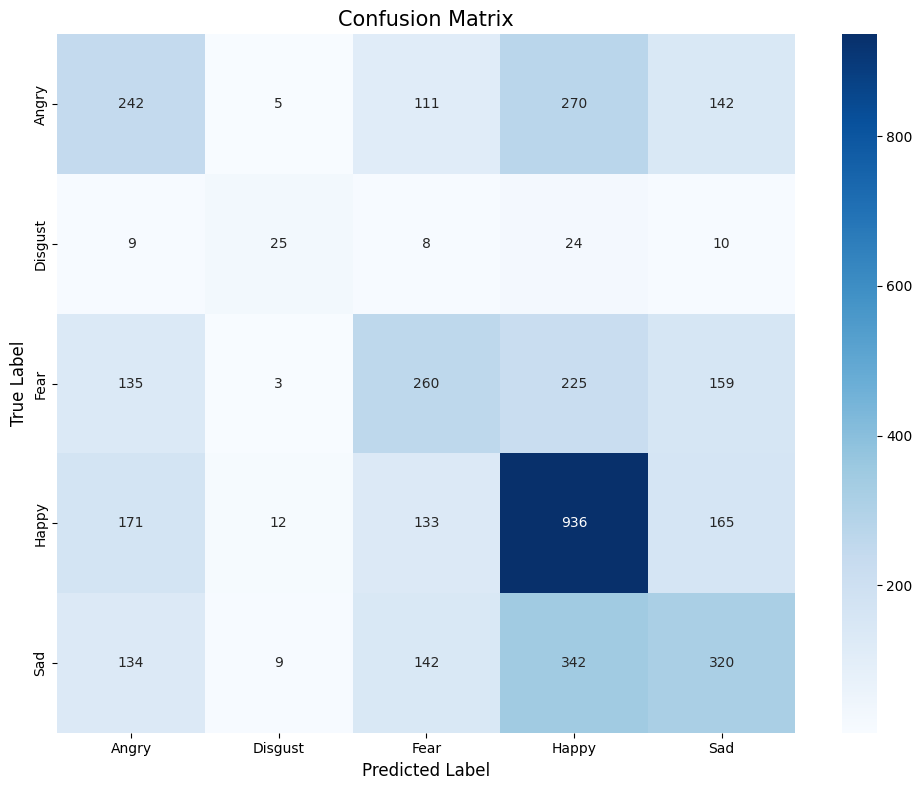

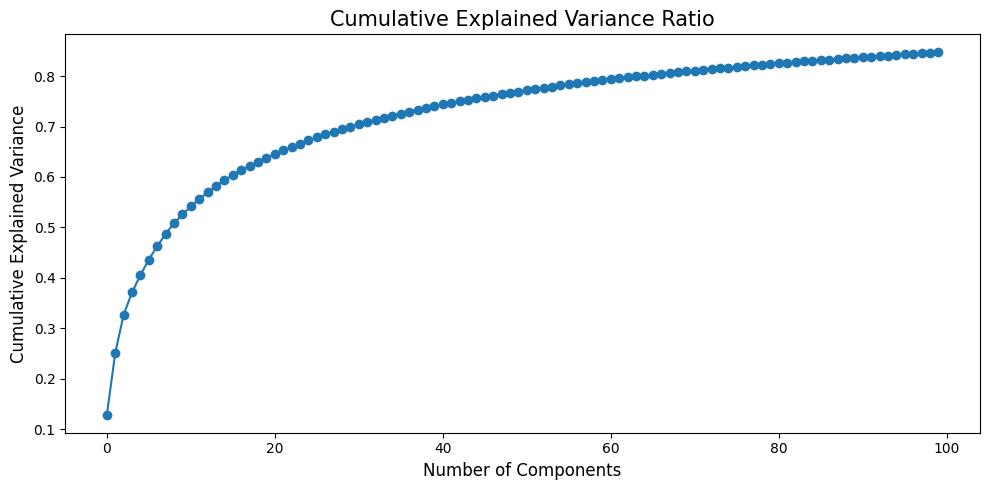

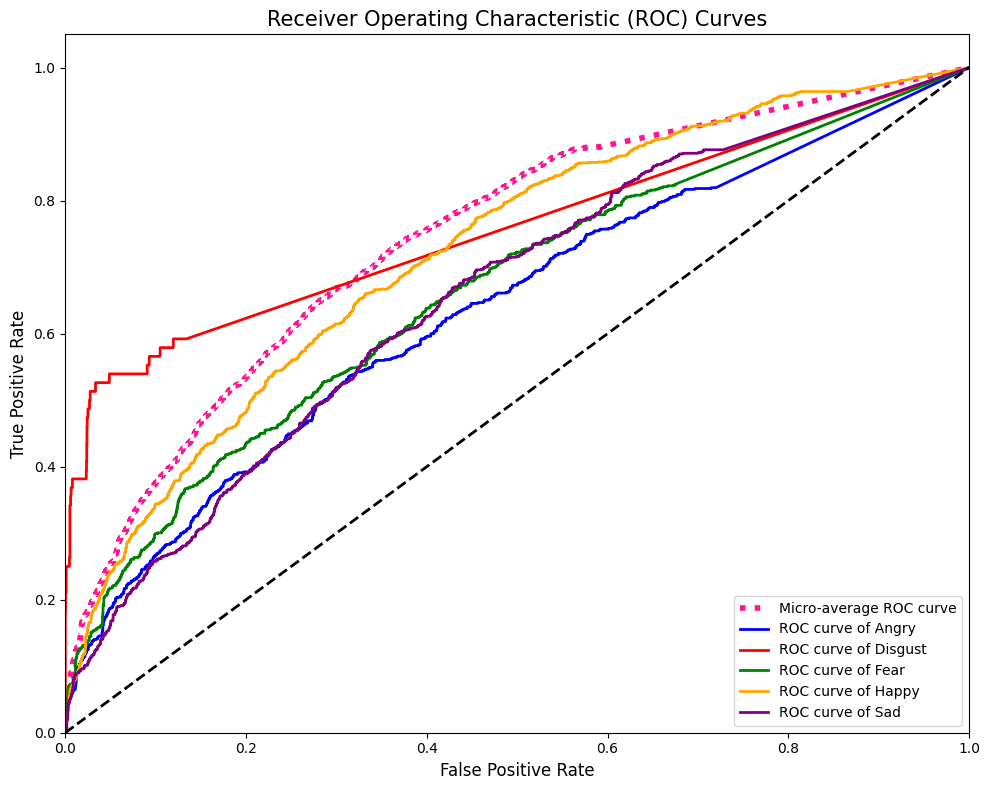

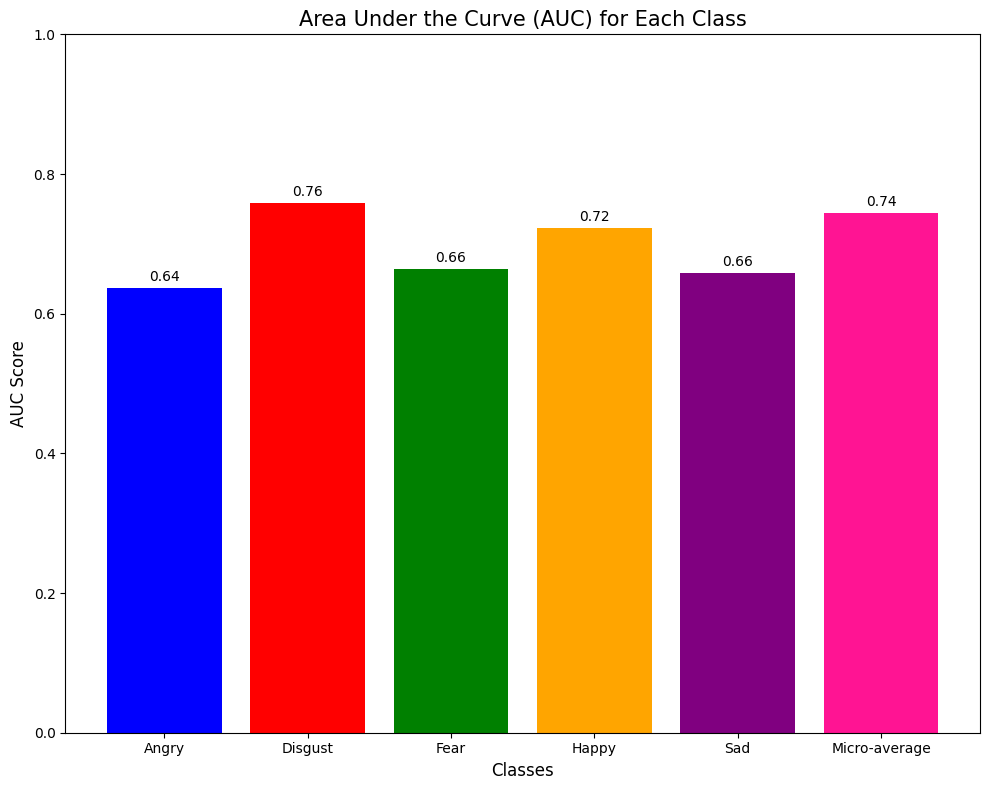


--- Model Performance ---
Accuracy: 0.4466
Loss Value: 5.0473

Classification Report:
              precision    recall  f1-score   support

       Angry       0.35      0.31      0.33       770
     Disgust       0.46      0.33      0.38        76
        Fear       0.40      0.33      0.36       782
       Happy       0.52      0.66      0.58      1417
         Sad       0.40      0.34      0.37       947

    accuracy                           0.45      3992
   macro avg       0.43      0.39      0.41      3992
weighted avg       0.43      0.45      0.44      3992



In [ ]:
# Visualize and report results
visualize_results(results, class_names)